The line of research is motivated by the need to accurately segment mitochondria from images. To solve this problem, we will use binary semantic segmentation using U-Net in Keras.

In [1]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob

## Prepare dataset

In [1]:
!pwd

/content


In [2]:
pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from patchify import patchify
import tifffile as tiff

We will use the foolowing dataset: https://www.epfl.ch/labs/cvlab/data/data-em/

We locate theses tif files of the images and masks in the main folder: ['training.tif'](https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif), ['testing.tif'](https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif), ['training_groundtruth.tif'](https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing.tif) and ['testing_groundtruth.tif'](https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing_groundtruth.tif).
Tif files include several images of 1024 x 768. We will cut them in 256 x 256 images using patchify.

In [36]:
large_image_train = tiff.imread(['training.tif'])
large_image_test = tiff.imread(['testing.tif'])
large_mask_train = tiff.imread('training_groundtruth.tif')
large_mask_test = tiff.imread('testing_groundtruth.tif')

Partition between train/test is 50/50. We concatenate images and masks and we will split de dataset into train test after.

In [37]:
large_image_stack = np.concatenate((large_image_train, large_image_test), axis=0)
large_mask_stack = np.concatenate((large_mask_train, large_mask_test), axis=0)

We extract patches from large images and masks and we save them. For this, we have to create the following routes:
* 'content/patches/images/'
* 'content/patches/masks/'

In [41]:
# We extract patches from large images and we save them
for img in range(large_image_stack.shape[0]):
  large_image = large_image_stack[img]
  patches_img = patchify(large_image, (256,256), step=256)

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img=patches_img[i,j,:,:]
      tiff.imwrite('patches/images/' + 'image_' + str(img) + '_' + str(i)+str(j)+ '.tif', single_patch_img)

In [42]:
# We extract patches from large masks and we save them.
for mask in range(large_mask_stack.shape[0]):
  large_mask = large_mask_stack[mask]
  patches_mask = patchify(large_mask, (256,256), step=256)

  for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
      single_patch_mask=patches_mask[i,j,:,:]
      tiff.imwrite('patches/masks/' + 'mask_' + str(mask) + '_' + str(i)+str(j)+ '.tif', single_patch_mask)

## Load data

In [43]:
image_directory = '/patches/images/'
mask_directory = '/patches/masks/'

In [54]:
SIZE = 256
num_images = 1000 # number of images to work with

Load images and masks in order so they match

In [47]:
image_names = glob.glob("/content/patches/images/*.tif")
print(image_names)

['/content/patches/images/image_245_10.tif', '/content/patches/images/image_53_13.tif', '/content/patches/images/image_171_03.tif', '/content/patches/images/image_265_11.tif', '/content/patches/images/image_135_10.tif', '/content/patches/images/image_25_10.tif', '/content/patches/images/image_235_20.tif', '/content/patches/images/image_125_03.tif', '/content/patches/images/image_123_12.tif', '/content/patches/images/image_169_10.tif', '/content/patches/images/image_32_03.tif', '/content/patches/images/image_269_02.tif', '/content/patches/images/image_139_20.tif', '/content/patches/images/image_158_23.tif', '/content/patches/images/image_236_00.tif', '/content/patches/images/image_191_13.tif', '/content/patches/images/image_20_11.tif', '/content/patches/images/image_291_00.tif', '/content/patches/images/image_229_22.tif', '/content/patches/images/image_144_13.tif', '/content/patches/images/image_267_23.tif', '/content/patches/images/image_118_22.tif', '/content/patches/images/image_124_

In [48]:
image_names.sort()
print(image_names)

['/content/patches/images/image_0_00.tif', '/content/patches/images/image_0_01.tif', '/content/patches/images/image_0_02.tif', '/content/patches/images/image_0_03.tif', '/content/patches/images/image_0_10.tif', '/content/patches/images/image_0_11.tif', '/content/patches/images/image_0_12.tif', '/content/patches/images/image_0_13.tif', '/content/patches/images/image_0_20.tif', '/content/patches/images/image_0_21.tif', '/content/patches/images/image_0_22.tif', '/content/patches/images/image_0_23.tif', '/content/patches/images/image_100_00.tif', '/content/patches/images/image_100_01.tif', '/content/patches/images/image_100_02.tif', '/content/patches/images/image_100_03.tif', '/content/patches/images/image_100_10.tif', '/content/patches/images/image_100_11.tif', '/content/patches/images/image_100_12.tif', '/content/patches/images/image_100_13.tif', '/content/patches/images/image_100_20.tif', '/content/patches/images/image_100_21.tif', '/content/patches/images/image_100_22.tif', '/content/p

In [55]:
image_names_subset = image_names[0:num_images] # We take the first 1000 images
image_dataset = np.array(images)
images = [cv2.imread(img, 0) for img in image_names_subset] # We read the images
image_dataset = np.expand_dims(image_dataset, axis = 3) # We expand dimensions

Read masks the same way. 

In [59]:
mask_names = glob.glob("/content/patches/masks/*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [60]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (1000, 256, 256, 1)
Mask data shape is:  (1000, 256, 256, 1)
Max pixel value in image is:  244
Labels in the mask are :  [  0 255]


## Preprocess data

In [66]:
# Normalize images
image_dataset_norm = image_dataset /255.  # Can also normalize or scale using MinMax scaler
# Do not normalize masks, just rescale to 0 to 1.
mask_dataset_norm = mask_dataset /255.  # PIxel values will be 0 or 1

We create the train/test partitions:

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset_norm, mask_dataset_norm, test_size = 0.20, random_state = 42)

We create the val partition:

In [77]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

## Visualize some data

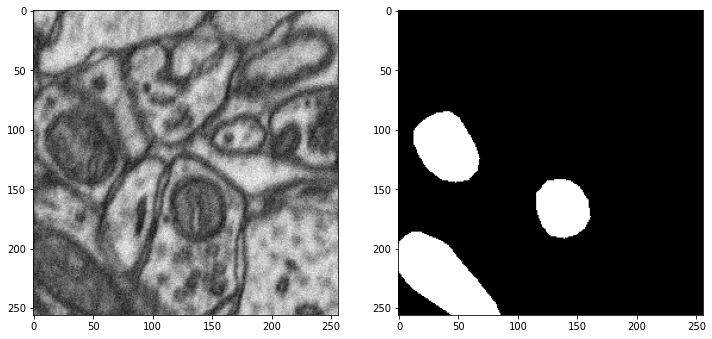

In [78]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

## Building U-Net model

In [73]:
# Building Unet by dividing encoder and decoder into blocks
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

# Decoder block
# Skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  # Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  # Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [79]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [80]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                     

## Training the model

In [81]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=25, 
                    validation_data=(X_val, y_val), 
                    shuffle=False)

Epoch 1/25
40/40 [==============================] - 39s 877ms/step - loss: 0.2295 - accuracy: 0.9250 - val_loss: 1572.7537 - val_accuracy: 0.0597
Epoch 2/25
40/40 [==============================] - 36s 897ms/step - loss: 0.0952 - accuracy: 0.9714 - val_loss: 58.4709 - val_accuracy: 0.1221
Epoch 3/25
40/40 [==============================] - 36s 911ms/step - loss: 0.0782 - accuracy: 0.9756 - val_loss: 3.3048 - val_accuracy: 0.5595
Epoch 4/25
40/40 [==============================] - 37s 932ms/step - loss: 0.0560 - accuracy: 0.9837 - val_loss: 1.0683 - val_accuracy: 0.8026
Epoch 5/25
40/40 [==============================] - 41s 1s/step - loss: 0.0433 - accuracy: 0.9871 - val_loss: 0.2228 - val_accuracy: 0.9329
Epoch 6/25
40/40 [==============================] - 38s 950ms/step - loss: 0.0374 - accuracy: 0.9887 - val_loss: 0.2160 - val_accuracy: 0.9466
Epoch 7/25
40/40 [==============================] - 40s 1s/step - loss: 0.0303 - accuracy: 0.9910 - val_loss: 0.2388 - val_accuracy: 0.9515
E

In [82]:
# Save the model for future use
model.save('/content/model.hdf5')

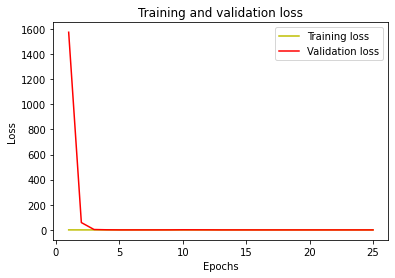

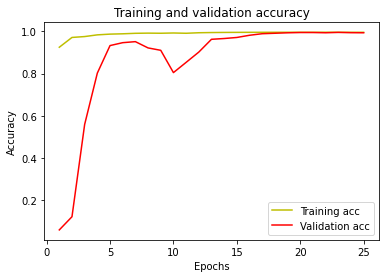

In [83]:
# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model evaluation

In [ ]:
# Load previously saved model
from keras.models import load_model
model = load_model("/content/model.hdf5", compile=False)        

First, we make predictions on the unseen test partition.

In [84]:
# We make predictions
y_pred=model.predict(X_test)

# Converts sigmoid probability to a clasification
y_pred_thresholded = y_pred > 0.5

We evaluate the model with the Intersection over union (IOU) metric on the onseen test partition.

In [87]:
from tensorflow.keras.metrics import MeanIoU

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9429932


We plot the predicted segmentation of a random test image:

(1, 256, 256, 1)
(256, 256)


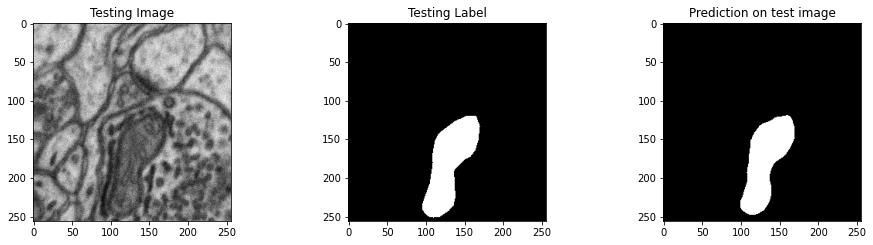

In [90]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()